
# Working with Netcd4-python data: Xarray tutorial

In this tutorial, we will use the features of the Python xarray library to process and analyze Netcdf files.

To install the library under anaconda:

$ conda install xarray


Here is an example of structure of a Netcdf file under xarray:
   

<img src = "./figures/xarray.png" alt = "xarray" width = "60%" height = "70%">


<b> DataArray </b>

xarray.DataArray is xarray’s implementation of a labeled, multi-dimensional array. It has several key properties:

<table border="1" class="docutils">
<colgroup>
<col width="27%">
<col width="57%">
</colgroup>
<tbody valign="top">
<tr><td><tt class="docutils literal"><span class="pre">values</span></tt></td>
<td> a numpy.ndarray holding the array’s values</td>
</tr>
<tr><td><tt class="docutils literal"><span class="pre">dims</span></tt></td>
<td>dimension names for each axis (e.g., ('x', 'y', 'z','time'))</td>
</tr>
<tr><td><tt class="docutils literal"><span class="pre">coords</span></tt></td>
<td>a dict-like container of arrays (coordinates) that label each point (e.g., 1-dimensional arrays of numbers, datetime objects or strings)</td>
</tr>
<tr><td><tt class="docutils literal"><span class="pre">attrs</span></tt></td>
<td>an OrderedDict to hold arbitrary metadata (attributes)</td>
</tr>
</tbody>
</table>


<b> DataSet </b>

xarray.Dataset is xarray’s multi-dimensional equivalent of a DataFrame. It is a dict-like container of labeled arrays (DataArray objects) with aligned dimensions. It is designed as an in-memory representation of the data model from the netCDF file format.


xarray.DataSet is a collection of DataArrays. Each NetCDF file contains a DataSet.

## 1- Open a Netcdf file

We will open and store the data of a Netcdf file in a Dataset.

First we need to import librairies and create aliases.

In [3]:
import xarray as xr
import warnings; warnings.filterwarnings(action='ignore')
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,5)

D:\Utilisateurs\guillaume\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
D:\Utilisateurs\guillaume\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


- To import and store as dataset only one Netcdf file:

We will work with temperature fields from cera20c reanalysis.

In [ ]:
unique_dataDIR = './DATA/CERA20C/cera20c_member0_TAS_197101_day.nc'
TAS = xr.open_dataset(unique_dataDIR)
TAS

- If we want to import several Netcdf files:

Here, we want to store all files' names starting with 'cera20c_member0_TAS_' and located in './data/cera20c/' path. 

In [ ]:
multi_dataDIR = './DATA/CERA20C/cera20c_member0_TAS_*.nc'
TAS2 = xr.open_mfdataset(multi_dataDIR)
TAS2

- Combine Netcdf:

To combine variables and coordinates between multiple DataArray and/or Dataset objects, use merge(). It can merge a list of Dataset, DataArray or dictionaries of objects convertible to DataArray objects:
 

In [ ]:
multi_dataDIR = './DATA/CERA20C/cera20c_member0_TAS_*.nc'
TAS2 = xr.open_mfdataset(multi_dataDIR)
multi_dataDIR2 = './DATA/CERA20C/cera20c_member0_SIC_*.nc'
SIC2 = xr.open_mfdataset(multi_dataDIR2)

DS_new = xr.merge([TAS2,SIC2])
DS_new

## 2- Exploring the data

We can quickly explore our datasets by using some methods of the xarray library: 

    - DS.var
    - DS.dims
    = DS.coords
    - DS.attrs

In [ ]:
DS_new.var

In [ ]:
DS_new.dims

In [ ]:
DS_new.coords

In [ ]:
DS_new.attrs

## 3- Basic operations with Xarray:

- Select a date:

We can use .sel() method to select one timestamp from our Dataset.

In [ ]:
DS_date = DS_new.sel(time='1971-01-01')
DS_date

- Select time range

We can select a time range with slicing 

In [ ]:
DS_date_range = DS_new.sel(time=slice('1971-06-01', '1971-08-31'))
DS_date_range

- Export a dataset

We can export our dataset into dataframe and then use Pandas library to make analysis. 

In [ ]:
df = DS_date_range.to_dataframe()

In [ ]:
df.head()

In [ ]:
df.describe()

- Time mean


In [ ]:
Mean_array = DS_date_range.mean(dim='time')
Mean_array.values

- To save our results into csv:

In [ ]:
Mean_array.t2m.to_dataframe().to_csv('./DATA/CERA20C_T2m_mean.csv')

- Mean over all latitudes and longitudes grid points: 

In [ ]:
DS_date_range.t2m.mean(dim=('latitude', 'longitude'))

In [ ]:
DS_date_range.t2m.mean(dim=('latitude', 'longitude')).plot()

- To save into csv:

In [ ]:
DS_date_range.t2m.mean(dim=('time', 'longitude')).to_dataframe().to_csv('./DATA/CERA20C_T2m_2Dmean.csv')

- Quick plot with Xarray

In [ ]:
import cartopy.crs as ccrs
fig=plt.figure(figsize=(10,10), frameon=True) 

ax = plt.axes(projection=ccrs.Orthographic(-80, 35))
Mean_array.t2m.plot.contourf(ax=ax, transform=ccrs.PlateCarree());
ax.set_global(); ax.coastlines();

- Basic operations with Xarray:

In this example, we will mean DS_date_range over time and apply a substration to change units. 


In [ ]:
centigrade = DS_date_range.t2m.mean(dim='time') - 273.16
centigrade.values

In [ ]:
fig=plt.figure(figsize=(10,10), frameon=True)
ax = plt.axes(projection=ccrs.Orthographic(-80, 35))
centigrade.plot.contourf(ax=ax, transform=ccrs.PlateCarree());
ax.set_global(); ax.coastlines();

- Groupby() method:

groupdby() method with Xarray is very usefull to group our datasets by month, season, year... and then apply function to compute indices.

In [ ]:
DS_new

In [ ]:
# monthly mean:
DS_month = DS_new.groupby('time.month').mean('time')
DS_month
#DS_month.to_dataframe()

We can use this method to compute climatology and then anomalies.

In [ ]:
climatology = DS_new.groupby('time.month').mean('time')
anomalies = DS_new.groupby('time.month') - climatology
anomalies

In [ ]:
# seaon mean:
DS_season = DS_new.groupby('time.season').mean('time')
DS_season

In [ ]:
# year mean:
DS_year = DS_new.groupby('time.year').mean('time')
DS_year

- to select a specific season:

In [ ]:
DS_winter = DS_season.sel(season='DJF')
DS_winter

In the example below, we will group the xarray.DataArray data by season, calculate the average, apply a simple arrhythmic operation and plot the resulting fields for each season. 

In [ ]:
DS_Season = DS_new.t2m.groupby('time.season').mean('time')- 273.15
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9,5))
j = 0
for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if season =='JJA':
        j += 1
        i = 0
    elif season =='SON':
        i = 1
        
    DS_Season.sel(season=season).plot.pcolormesh(
        ax=axes[i, j], vmin=-30, vmax=30, cmap='Spectral_r',
        add_colorbar=True, extend='both')

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis('tight')
   
plt.tight_layout()
fig.suptitle('Seasonal Surface Air Temperature', fontsize=16, y=1.02)

In [ ]:

lat_bnd = [80, 50]
lon_bnd = [250, 310]
DS_Season = DS_new.sel(longitude=slice(*lon_bnd), latitude=slice(*lat_bnd),).siconc.groupby('time.season').mean('time') *100

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
j = 0
for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if season =='JJA':
        j += 1
        i = 0
    elif season =='SON':
        i = 1
        
    DS_Season.sel(season=season).plot.pcolormesh(
        ax=axes[i, j], vmin=0, vmax=100, cmap='Spectral_r',
        add_colorbar=True, extend='both')
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis('tight')
   
plt.tight_layout()
fig.suptitle('Seasonal Sea Ice Concentration', fontsize=16, y=1.02)

To save our result into Netcdf: 

In [ ]:
DS_season = DS_new.groupby('time.season').mean('time')
dataDIR = './DATA/CERA20C_season.nc'
DS_Season.to_netcdf(dataDIR)


##  4- Select grid points from Netcdf file using Xarray

In the previous section we applied the .sel () method to work on the time dimension. This method can be used on spatial dimensions to extract points or study areas from our netcdf file.

### Gridpoint:  to extract the closest grid point of a latitude / longitude: 

In [ ]:
lati = 45.5
loni = 269.2
data  = DS_new.sel(longitude=loni  , latitude=lati  , method='nearest') 
data

In [ ]:
data['t2m'] = data['t2m'] - 273.15

In [ ]:
data.t2m

We can convert our selection into a DataFrame and then use Pandas to analyse our results.

In [ ]:
df = data.t2m.to_dataframe()
fig = plt.figure(figsize=(16,8))
df['t2m'].plot()


### Gridpoints:  to extract a list of points

In [ ]:
lats =  [20.0,50.0,90.0]
lons =  [60.0,80.0,120.0]

data  = DS_new.sel(longitude=lons  , latitude=lats  , method='nearest')
data['t2m'] = data['t2m']-273.15
data

In [ ]:
fig = plt.figure(figsize=(16,8))
data.t2m.sel(longitude=60.0, latitude=[20.0,50.0,90.0]).plot.line(x='time')

### To extract an area or subdomain delimited by latitude and longitude values: .slicing() 

In [ ]:
lat_bnd = [80, 50]
lon_bnd = [250, 310]
area = DS_new.sel(longitude=slice(*lon_bnd), latitude=slice(*lat_bnd),)
area

In [ ]:
area.longitude.values

To visualize our area:: 

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeat
def make_figure():
    fig = plt.figure(figsize=(22, 12))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    # generate a basemap with country borders, oceans and coastlines
    ax.add_feature(cfeat.LAND)
    ax.add_feature(cfeat.OCEAN)
    ax.add_feature(cfeat.COASTLINE)
    ax.add_feature(cfeat.BORDERS, linestyle='dotted')
    return fig, ax

make_figure();

In [ ]:
_, ax = make_figure()
# plot the temperature field
area.t2m[0].plot()

### To mask an area delimited by a Shapefile:

To do this, we need to import two more librairies: 
- Geopandas: conda install -c conda-forge geopandas
- osgeo: conda install -c conda-forge gdal

The next function will open a shapefile, read the polygons and make a mask from each grid points of our Netcdf inside the polygons. 

In [14]:
from osgeo import ogr
import geopandas as gpd
import numpy as np
def get_mask(lons2d, lats2d, shp_path="", polygon_name=None):
    """
    Assumes that the shape file contains polygons in lat lon coordinates
    :param lons2d:
    :param lats2d:
    :param shp_path:
    :rtype : np.ndarray
    The mask is 1 for the points inside of the polygons
    """
    ds = ogr.Open(shp_path)
    """
    :type : ogr.DataSource
    """

    xx = lons2d.copy()
    yy = lats2d

    # set longitudes to be from -180 to 180
    xx[xx > 180] -= 360

    mask = np.zeros(lons2d.shape, dtype=int)
    nx, ny = mask.shape

    pt = ogr.Geometry(ogr.wkbPoint)

    for i in range(ds.GetLayerCount()):
        layer = ds.GetLayer(i)
        """
        :type : ogr.Layer
        """

        for j in range(layer.GetFeatureCount()):
            feat = layer.GetFeature(j)
            """
            :type : ogr.Feature
            """

            # Select polygons by the name property
            if polygon_name is not None:
                if not feat.GetFieldAsString("NAME") == polygon_name:
                    continue

            g = feat.GetGeometryRef()
            """
            :type : ogr.Geometry
            """

            assert isinstance(g, ogr.Geometry)

            for pi in range(nx):
                for pj in range(ny):
                    pt.SetPoint_2D(0, float(xx[pi, pj]), float(yy[pi, pj]))

                    mask[pi, pj] += int(g.Contains(pt))

    return mask


We first read the Netcdf file and store informations in a Xarray.dataset. 


In [15]:
 ds = xr.open_dataset('./DATA/CERA20C/cera20c_member0_TAS_197101_day.nc')

We then need to extract latitudes and longitudes values and compute a 2D matrix. 

In [16]:
Imp_Lats =  ds['latitude'].values
Imp_Lons =  ds['longitude'].values
lon2d, lat2d = np.meshgrid(Imp_Lons, Imp_Lats)

In [17]:
ds_mean = ds.mean('time') - 273.15
ds_mean

<xarray.Dataset>
Dimensions:    (latitude: 145, longitude: 288)
Coordinates:
  * longitude  (longitude) float32 0.0 1.25 2.5 3.75 ... 356.25 357.5 358.75
  * latitude   (latitude) float32 90.0 88.75 87.5 86.25 ... -87.5 -88.75 -90.0
Data variables:
    t2m        (latitude, longitude) float32 -34.067184 ... -25.249802

We open the shape file with Geopandas library.

In [18]:
shapes = gpd.read_file("./DATA/Shapefiles/Countries_Final-polygon.shp")
list(shapes.columns.values)

['FIPS',
 'ISO2',
 'ISO3',
 'UN',
 'NAME',
 'AREA',
 'POP2005',
 'REGION',
 'SUBREGION',
 'LON',
 'LAT',
 'layer',
 'path',
 'geometry']

In [19]:
shapes

,FIPS,ISO2,ISO3,UN,NAME,AREA,POP2005,REGION,SUBREGION,LON,LAT,layer,path,geometry
0,NT,AN,ANT,530,Bonaire,80,186392,19,29,-68.870,12.123,Single parts,C:/Users/Aspire/Desktop/ZIKA analysis with new...,POLYGON ((-68.19528200000002 12.22110899999996...
1,NT,AN,ANT,530,Curacao,80,186392,19,29,-68.870,12.123,Single parts,C:/Users/Aspire/Desktop/ZIKA analysis with new...,POLYGON ((-68.96556099999998 12.19888900000001...
2,NT,AN,ANT,530,Netherlands Antilles,80,186392,19,29,-68.870,12.123,Single parts,C:/Users/Aspire/Desktop/ZIKA analysis with new...,"POLYGON ((-62.96111299999995 17.4608310000001,..."
3,AC,AG,ATG,28,Antigua and Barbuda,44,83039,19,29,-61.783,17.078,Studied_countries,C:\Users\Aspire\Desktop\ZIKA analysis with new...,"(POLYGON ((-61.686668 17.02444100000014, -61.7..."
4,AR,AR,ARG,32,Argentina,273669,38747148,19,5,-65.167,-35.377,Studied_countries,C:\Users\Aspire\Desktop\ZIKA analysis with new...,(POLYGON ((-68.60861199999994 -54.891395999999...
5,BB,BB,BRB,52,Barbados,43,291933,19,29,-59.559,13.153,Studied_countries,C:\Users\Aspire\Desktop\ZIKA analysis with new...,"POLYGON ((-59.533058 13.050554, -59.543335 13...."
6,BD,BM,BMU,60,Bermuda,5,64174,19,21,-64.709,32.336,Studied_countries,C:\Users\Aspire\Desktop\ZIKA analysis with new...,(POLYGON ((-64.85583500000001 32.2786100000001...
7,BF,BS,BHS,44,Bahamas,1001,323295,19,29,-78.014,24.628,Studied_countries,C:\Users\Aspire\Desktop\ZIKA analysis with new...,(POLYGON ((-73.03723099999996 21.1394420000000...
8,BH,BZ,BLZ,84,Belize,2281,275546,19,13,-88.602,17.219,Studied_countries,C:\Users\Aspire\Desktop\ZIKA analysis with new...,(POLYGON ((-87.80334499999992 17.2941670000001...
9,BL,BO,BOL,68,Bolivia,108438,9182015,19,5,-64.671,-16.715,Studied_countries,C:\Users\Aspire\Desktop\ZIKA analysis with new...,"POLYGON ((-65.190201 -22.09473, -65.5988920000..."


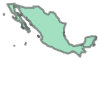

In [12]:
shapes.loc[27, 'geometry']

We want in our study to extract information inside Mexico shapefile.

In [13]:
mask=get_mask(lon2d,lat2d,shp_path="./DATA/Shapefiles/Countries_Final-polygon.shp", polygon_name='Mexico') 
np.max(mask)

1

We will convert our mask into numpy 2D array. We'll be later able to apply this matrix to mask our Netcdf file. 

In [ ]:
np.save('DATA/Mexico.npy',mask) # saving our mask in numpy.array

We will mask our area using .where() method. 

In [ ]:
ds_mask = ds_mean.where(mask == 1) 
ds_mask.to_netcdf('DATA/Mexico.nc')  # we want to save our shapefile mask in Netcdf format

In [ ]:
ds_mask

In [ ]:
np.max(ds_mask.t2m)

In [ ]:
_, ax = make_figure()
# plot the temperature field
lat_bnd = [35, 0]
lon_bnd = [240, 280]
ds_mask.t2m.sel(longitude=slice(*lon_bnd), latitude=slice(*lat_bnd),).plot.pcolormesh(vmin=0, vmax=30, cmap='Spectral',add_colorbar=True, extend='both')

##  5- Last example using Xarray: 

In this section, We will calculate the seasonal accumulation of the precipitation, extract a region, plot the domain and record our result in Netcdf:

In [ ]:
# Let's open cera20c_enda_ep_PR_*.nc netcdf files 
multi_dataDIR = './DATA/CERA20C/cera20c_enda_ep_PR_*.nc'
array = xr.open_mfdataset(multi_dataDIR)
array.tp

All Netcdf files are stored in DataArray container, we can now group our Datasets by season, apply a simple sum() method over time and then change units from meters to mm.

In [ ]:
array_season = array.groupby('time.season').sum('time')*1000
array_season

We want to extract a specific domain delimited: 
    - latitude boundaries: 50N to 70N
    - longitude boudaries: 250E to 310E
    
We finally want to extract winter season. 

In [ ]:
lat_bnd = [70, 50]
lon_bnd = [250, 310]
subset_season_DJF = array_season.sel(season = 'DJF', longitude=slice(*lon_bnd), latitude=slice(*lat_bnd),)
subset_season_DJF

Let's save the Dataset to Netcdf. 

In [ ]:
dataDIR = './DATA/subset_season.nc'
subset_season_DJF.to_netcdf(dataDIR)

We can call our make_figure() function to quick plot our Dataset. 

In [ ]:
_, ax = make_figure()
# plot the temperature field
subset_season_DJF.tp.plot.pcolormesh(vmin=0, vmax=200, cmap='Spectral',add_colorbar=True, extend='both')

In [ ]:
array_season

In [2]:
import xarray as xr
multi_dataDIR = 'D:/ANUSPLIN_10km/Netcdf/tasmin/ANUSPLIN_10km_tasmin_ll_*_01_d.nc'
TAS2 = xr.open_mfdataset(multi_dataDIR)

D:\Utilisateurs\guillaume\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
D:\Utilisateurs\guillaume\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


ValueError: unable to decode time units 'days since  1950-01-00 00:00:00' with calendar 'proleptic_gregorian'. Try opening your dataset with decode_times=False.